<a href="https://colab.research.google.com/github/Parisa-Foroutan/Tutorials/blob/main/ADMI821-%20Winter%202022/ADMI821_Session5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Session 5:**

Find it on GitHub: https://github.com/Parisa-Foroutan/Tutorials/blob/main/ADMI821_Session5.ipynb

This document is Adapted from [Aishwarya Singh](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/).

In this session various ensemble learning models will be presented. You can find the datasets here: [nasa.csv ](https://drive.google.com/file/d/1JPUOwwIuFbyIWPNyMCWj78S-CIuqb75d/view?usp=sharing) , and [life expectancy](https://drive.google.com/file/d/1F8bGNt7ZE7fINFkvTBITCfu1TqB_t5Re/view?usp=sharing).

Import Libraries:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

from sklearn import linear_model, feature_selection, metrics, naive_bayes, neighbors, svm, tree

###Read the Data:

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Nasa Dataset
classification_data = pd.read_csv("/content/drive/MyDrive/Datasets/nasa.csv")
classification_data.head(3)

,Name,Eccentricity,Inclination,Hazardous,Neo Reference ID,Absolute Magnitude,Est Dia in Feet(min),Est Dia in Feet(max),Close Approach Date,Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Semi Major Axis,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion
0,3723955,0.351674,28.412996,0,3723955,21.3,479.225620,1071.581063,12784,7.890000e+11,18.113985,65210.34609,40519.17311,0.383014,148.992630,3,0.186935,5.457,1.107776,136.717242,425.869294,0.718200,313.091975,1.497352,2457794.969,173.741112,0.845330
1,2446862,0.348248,4.237961,1,2446862,20.3,759.521423,1698.341531,12791,7.900000e+11,7.590711,27326.56018,16979.66180,0.050956,19.821890,0,0.043058,4.557,1.458824,259.475979,643.580228,0.950791,248.415038,1.966857,2458120.468,292.893654,0.559371
2,3671135,0.563441,17.927751,0,3671135,19.6,1048.431420,2344.363926,12798,7.900000e+11,10.808844,38911.83825,24178.30305,0.392785,152.793274,1,0.272213,4.724,1.323532,178.971951,556.160556,0.577800,198.145969,2.069265,2458009.403,354.237368,0.647295


In [ ]:
from sklearn.model_selection import train_test_split

X_c = classification_data.iloc[:, 1:-1]
y_c = classification_data["Hazardous"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size = 0.2, random_state = 123)
print(f"Shape of X_train: {X_train_c.shape}")

Shape of X_train: (369, 25)


Read the forecasting data:

In [ ]:
Forecasting_data = pd.read_csv("/content/drive/MyDrive/Datasets/life_dexpectency.csv") # life_expectancy dataset

Forecasting_data.head(3)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9


In [ ]:
Forecasting_data.dropna(inplace=True)

Split the data into train and test subsets (Note: Time series data cannot be randomly subsampled):

In [ ]:
## using life expectency dataset

X = Forecasting_data.iloc[:, 4:]
y = Forecasting_data.iloc[:, 3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

## Ensemble Learning

You can find sklearn documentations for ensemble models [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble).

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingRegressor, StackingClassifier, \
                             BaggingRegressor, BaggingClassifier

### Max Voting

In [ ]:
# from pandas.core.common import random_state
clf1 = tree.DecisionTreeClassifier(random_state=12)
clf2 = neighbors.KNeighborsClassifier(n_neighbors= 5)
clf3= linear_model.LogisticRegression(random_state=12)
clf4= svm.SVC(kernel ='rbf')

clf1.fit(X_train_c,y_train_c)
clf2.fit(X_train_c,y_train_c)
clf3.fit(X_train_c,y_train_c)

pred1=clf1.predict(X_test_c)
pred2=clf2.predict(X_test_c)
pred3=clf3.predict(X_test_c)

from statistics import mode
final_pred = np.array([])
for i in range(0,len(X_test_c)):
    final_pred = np.append(final_pred, mode([pred1[i], pred2[i], pred3[i]]))

# Alternatively, you can use “VotingClassifier” module in sklearn:
clf = VotingClassifier(estimators=[('dt', clf1), ('lr', clf3)], voting='hard')
clf.fit(X_train_c,y_train_c)
clf.score(X_test_c,y_test_c)

0.45161290322580644

### Averaging
We generally use the average of individual prediction models to make a final prediction for regression tasks. For classification tasks, averaging is used to predict ensemble probability predictions.

In [ ]:
model1 = svm.SVR(kernel ='rbf')
model2 = neighbors.KNeighborsRegressor(n_neighbors=5)
model3 = linear_model.LinearRegression()

model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train,y_train)

pred1=model1.predict(X_test)
pred2=model2.predict(X_test)
pred3=model3.predict(X_test)

finalpred=(pred1+pred2+pred3)/3
print(finalpred[:5])

# Weighted Average
weights = [0.3, 0.4, 0.3]
finalpred_weighted=(pred1*weights[0]+pred2*weights[1]+pred3*weights[2])
print(finalpred_weighted[:5])

[72.04105721 68.80687088 69.16811221 65.30730528 71.7140467 ]
[72.14095149 69.26018379 69.63730099 65.53057475 71.24264203]


### Stacking
Stacking involves combining the predictions from multiple machine learning models on the same dataset. Each model fits the data via k-fold cross-validation, where the out-of-fold predictions are used as the basis for the training dataset for the meta-model.


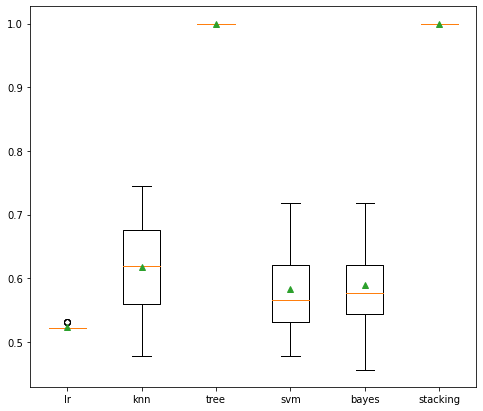

In [ ]:
# define a stacking ensemble of models
def get_stacking():
	# define the base estimators
	base_models = []
	base_models.append(('lr', linear_model.LogisticRegression()))
	base_models.append(('knn', neighbors.KNeighborsClassifier()))
	base_models.append(('tree', tree.DecisionTreeClassifier()))
	base_models.append(('svm', svm.SVC()))
	base_models.append(('bayes', naive_bayes.GaussianNB()))
	# define final learner model
	final_estimator = linear_model.LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=base_models, final_estimator=final_estimator, cv=5)
	return model

# define a dict of models to evaluate
def get_models():
    models = dict()
    models['lr'] = linear_model.LogisticRegression()
    models['knn'] = neighbors.KNeighborsClassifier()
    models['tree'] = tree.DecisionTreeClassifier()
    models['svm'] = svm.SVC()
    models['bayes'] = naive_bayes.GaussianNB()
    models['stacking'] = get_stacking()
    return models

# evaluate a model using cross-validation
def evaluate_model(model, X, y):
	cv = sk.model_selection.RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
	scores = sk.model_selection.cross_val_score(model, X, y, scoring='accuracy', cv=cv, error_score='raise')
	return scores

models = get_models()

# evaluate the models and store results
results, names = [], []
for key, model in models.items():
    # scores = evaluate_model(model, X_train_c, y_train_c)
    scores = evaluate_model(model, X_c, y_c)
    results.append(scores)
    names.append(key)

# plot model performance for comparison
plt.figure(figsize=(8,7))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

### Bagging



1.   Multiple subsets are created from the original dataset, selecting observations with replacement (Bagging method).
2.   A base model (weak model) is created on each of these subsets.
3. The models run in parallel and are independent of each other.
4. The final predictions are determined by combining the predictions from all the models


In [ ]:
model = BaggingRegressor(tree.DecisionTreeRegressor(random_state=1), random_state=1)
model.fit(X_train, y_train)
print("R2 is: {}".format(model.score(X_test,y_test))) # this returns R2
mse = metrics.mean_squared_error(y_test, model.predict(X_test))
print("MSE is: {}".format(mse))

R2 is: 0.9481369580381593
MSE is: 4.392671898734175


Random Forest is an example of Bagging algorithms.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, criterion="squared_error", max_depth=3,min_samples_leaf=0.1, max_features="auto",
                              bootstrap=True, oob_score=True, max_samples=0.8, random_state=1)
model.fit(X_train, y_train)
print("R2 is: {}".format(model.score(X_test,y_test))) # this returns R2
mse = metrics.mean_squared_error(y_test, model.predict(X_test))
print("MSE is: {}".format(mse))

R2 is: 0.764438862381576
MSE is: 19.95144809306864


In [ ]:
print("Feature importance scores: {}".format(model.feature_importances_))
model.apply(X_test[0:1]) # returns X_leaves ndarray of shape (n_samples, n_estimators)

Feature importance scores: [0.08002955 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.09140333
 0.         0.         0.00138213 0.         0.82718498 0.        ]


array([[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 4, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 4, 5, 4, 4, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 4, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5,
        5, 4, 5, 5, 4, 4, 5, 5, 5, 5, 5, 6]])

### Boosting

Boosting is a sequential process, where each subsequent model attempts to correct the errors of the previous model. The succeeding models are dependent on the previous model. Thus, the boosting algorithm combines a number of weak learners to form a strong learner.

AdaBoost and GradientBoost are examples of boosting algorithms. Regression trees used as a base learner for the GradientBoosting algorithm.

In [ ]:
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier

base_estimator = tree.DecisionTreeRegressor(random_state=1) # neighbors.KNeighborsRegressor(8)
model = AdaBoostRegressor(base_estimator= base_estimator,
                          n_estimators=50, learning_rate=1, loss="linear", random_state=1)
model.fit(X_train, y_train)
print("R2 is: {}".format(model.score(X_test,y_test))) # this returns R2
mse = metrics.mean_squared_error(y_test, model.predict(X_test))
print("MSE is: {}".format(mse))

R2 is: 0.9600622043554854
MSE is: 3.3826329113924043


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

model = GradientBoostingRegressor(loss="squared_error", learning_rate=0.5, n_estimators=100, min_samples_leaf=0.1,
                                  max_depth=3, min_impurity_decrease=0, random_state=1)
model.fit(X_train, y_train)
print("R2 is: {}".format(model.score(X_test,y_test))) # this returns R2
mse = metrics.mean_squared_error(y_test, model.predict(X_test))
print("MSE is: {}".format(mse))

R2 is: 0.9376928076378708
MSE is: 5.277265710320788


For more boosting algorithms look at [xgboost](https://xgboost.readthedocs.io/en/stable/index.html#xgboost-documentation) and [lightgbm](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html#python-package-introduction)  libraries.